# Optimización multiobjetivo

- La optimización multiobjetivo trata de encontrar soluciones que optimicen varias funciones objetivo simultáneamente.
- En la mayoría de los casos, estas funciones objetivo están en conflicto entre sí, lo que significa que mejorar una puede resultar en el empeoramiento de otra.

## Un Problema de optimización multiobjetivo (MOP, por sus sigas en inglés)

Formalmente, un problema de optimización multiobjetivo puede expresarse como:

$$\min \mathbf{f}(\mathbf{x}) = \min (f_1(\mathbf{x}), f_2(\mathbf{x}), \dots, f_m(\mathbf{x}))$$

sujeto a:

$$ \mathbf{x} \in X $$

donde $ \mathbf{x} $ es el vector de decisión, $ f_1, f_2, \dots, f_m $ son las funciones objetivo, y $ X $ es el espacio factible de soluciones.


## Ejemplo: Un MOP con dos variables y dos objetivos: el problema **Dent**

- Considera un problema de optimización con dos variables y dos objetivos.
- Este tipo de problema puede representarse gráficamente, donde cada eje representa un objetivo diferente.
- Las soluciones óptimas no se encuentran en un solo punto, sino en un conjunto de puntos que forman lo que se llama el **frente de Pareto**.

### El problema Dent
- Es un problema biobjetivo definido sobre dos variables de decisión con límites en el intervalo $[-1.5, 1.5]$.
- Los dos objetivos a minimizar son $f_1$ y $f_2$, que se definen mediante fórmulas que incluyen una combinación de expresiones cuadráticas y una función exponencial.
- Este problema es interesante porque introduce una "dentadura" en el frente de Pareto, lo que lo hace útil para probar la capacidad de los algoritmos en identificar y preservar frentes no suaves.

- Las funciones objetivo se definen como:

$$
f_1(x_1, x_2) = 0.5 \left(\sqrt{1 + (x_1 + x_2)^2} + \sqrt{1 + (x_1 - x_2)^2} + x_1 - x_2\right) + d
$$

$$
f_2(x_1, x_2) = 0.5 \left(\sqrt{1 + (x_1 + x_2)^2} + \sqrt{1 + (x_1 - x_2)^2} - x_1 + x_2\right) + d
$$

 donde:
  - $x_1, x_2\in[-1.5, 1.5]$ son las variables de diseño del problema.
  - $d$ es una perturbación o dentadura definida como:

$$ d = \lambda \cdot \exp\left(-\left(x_1 - x_2\right)^2\right) $$

- $\lambda$ es un parámetro que controla el término adicional $ d $.



In [1]:
#!pip install deap

In [2]:
# Importamos bibliotecas
from deap import base, creator, tools, algorithms
import random
import numpy as np
import matplotlib.pyplot as plt
import math

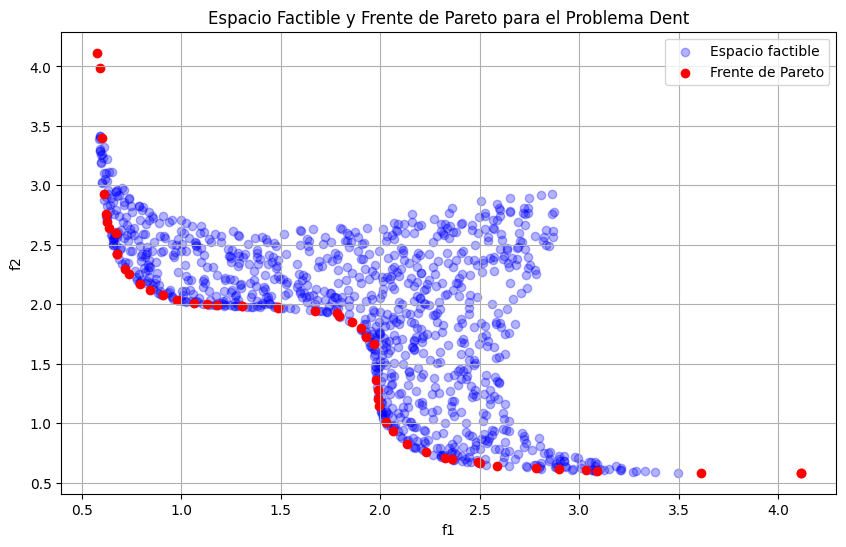

In [3]:
# Definir la función Dent
def dent(individual, lbda=0.85):
    """
    Implementa la función Dent
    Num. variables = 2; limites in [-1.5, 1.5]; num. objetivos = 2.
    """
    d  = lbda * math.exp(-(individual[0] - individual[1]) ** 2)
    f1 = 0.5 * (math.sqrt(1 + (individual[0] + individual[1]) ** 2) +
                math.sqrt(1 + (individual[0] - individual[1]) ** 2) +
                individual[0] - individual[1]) + d
    f2 = 0.5 * (math.sqrt(1 + (individual[0] + individual[1]) ** 2) +
                math.sqrt(1 + (individual[0] - individual[1]) ** 2) -
                individual[0] + individual[1]) + d
    return f1, f2

# Configuración del toolbox de DEAP
toolbox = base.Toolbox()

# Crear tipos de fitness y de individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Definir la población
toolbox.register("attr_float", random.uniform, -1.5, 1.5)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operadores genéticos
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.1, indpb=0.2)
toolbox.register("evaluate", dent)

# Parámetros del algoritmo
toolbox.pop_size = 50
toolbox.max_gen = 10
toolbox.mut_prob = 0.2

# Ejecución del algoritmo NSGA-II
def run_nsga2(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])
    toolbox.register("select", tools.selNSGA2)
    population, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size,
                                     lambda_=toolbox.pop_size,
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob,
                                     stats=stats,
                                     ngen=toolbox.max_gen,
                                     verbose=verbose)
    last_pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]
    return population, logbook, last_pareto_front

# Definir las estadísticas
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

# Ejecutar NSGA-II
pop, log, hof = run_nsga2(toolbox, stats=stats)

# Mostrar resultados
pareto_front = np.array([ind.fitness.values for ind in hof])  # Obtener los puntos del frente de Pareto
#print("Frente de Pareto:")
#print(pareto_front)

# Generar soluciones aleatorias en el espacio de búsqueda
n_samples = 1000  # Número de soluciones aleatorias a generar
samples = [creator.Individual([random.uniform(-1.5, 1.5) for _ in range(2)]) for _ in range(n_samples)]

# Evaluar todas las soluciones
evaluated_samples = np.array([dent(ind) for ind in samples])

# Graficar el espacio factible de soluciones
plt.figure(figsize=(10, 6))
plt.scatter(evaluated_samples[:, 0], evaluated_samples[:, 1], c='blue', alpha=0.3, label='Espacio factible')
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c='red', label='Frente de Pareto')
plt.title('Espacio Factible y Frente de Pareto para el Problema Dent')
plt.xlabel('f1')
plt.ylabel('f2')
plt.legend()
plt.grid(True)
plt.show()


## **Caso de estudio 4: Optimización de portafolio multiobjetivo**

- El problema de optimización de portafolio se basa en asignar diferentes proporciones de capital a un conjunto de activos financieros para maximizar la rentabilidad esperada y minimizar el riesgo asociado (medido por la varianza o desviación estándar de los retornos).

### Objetivos:
1. Maximizar el retorno esperado del portafolio.
2. Minimizar el Riesgo (Varianza/Desviación Estándar) del Portafolio.

### **Formulación matemática:**
Dado un conjunto de $ n $ activos financieros, con retornos esperados $ r_i $ y una matriz de covarianza $ \Sigma $ que representa la relación entre los activos:

- **Retorno esperado**:
  $$
  f_1(\mathbf{x}) = \sum_{i=1}^{n} x_i \cdot r_i
  $$
  donde $ x_i $ es la proporción del capital invertido en el activo $ i $, con $ \sum_{i=1}^{n} x_i = 1 $.

- **Riesgo (varianza)**:
  $$
  f_2(\mathbf{x}) = \mathbf{x}^T \Sigma \mathbf{x}
  $$
  donde $ \mathbf{x} $ es el vector de proporciones $ [x_1, x_2, \dots, x_n] $.

- **Restricciones**:
- $ \sum_{i=1}^{n} x_i = 1 $ (La suma de todas las proporciones debe ser 1).
- $ x_i \geq 0 $ (No se permite venta en corto).


In [4]:
# Datos del problema de optimización de portafolio
returns = np.array([0.05, 0.18, 0.15, 0.10, 0.08])
cov_matrix = np.array([
    [0.1, 0.01, 0.02, 0.03, 0.04],
    [0.01, 0.07, 0.05, 0.06, 0.07],
    [0.02, 0.05, 0.05, 0.08, 0.05],
    [0.03, 0.06, 0.08, 0.07, 0.03],
    [0.04, 0.07, 0.05, 0.03, 0.08]
])

def normalize(individual):
    total = sum(individual)
    return [i/total for i in individual]

def evaluate_portfolio(individual):
    """Implementa la función de evaluación para el problema de optimización de portafolio."""
    normalized_individual = normalize(individual)
    portfolio_return = np.dot(normalized_individual, returns)
    portfolio_risk = np.dot(np.dot(normalized_individual, cov_matrix), normalized_individual)
    return portfolio_return, portfolio_risk

def custom_mutate(individual, low, up, eta, indpb):
    mutated_ind = tools.mutPolynomialBounded(individual, low=low, up=up, eta=eta, indpb=indpb)
    nuevo = creator.Individual(mutated_ind[0]/np.sum(mutated_ind[0]))
    return (nuevo,)

def custom_cx(ind1, ind2, low, up, eta):
    c1, c2 = tools.cxSimulatedBinaryBounded(ind1, ind2, eta, low, up)
    c1 = creator.Individual(c1/np.sum(c1))
    c2 = creator.Individual(c2/np.sum(c2))

    return c1, c2


In [5]:
# Definir el toolbox para el problema de portafolio
toolbox = base.Toolbox()

# Crear los tipos de fitness y de individuo
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))  # Maximize retorno, minimize riesgo
creator.create("Individual", list, fitness=creator.FitnessMulti)

ndim = len(returns)

toolbox.register("attr_float", random.uniform, 0., 1.)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=ndim)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", custom_cx, low=0.0, up=1.0, eta=5)
toolbox.register("mutate", custom_mutate, low=0.0, up=1.0, eta=5, indpb=1.0/ndim)
toolbox.register("evaluate", evaluate_portfolio)

toolbox.pop_size = 30
toolbox.max_gen = 10
toolbox.mut_prob = 0.2


d:\Programs\Python\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


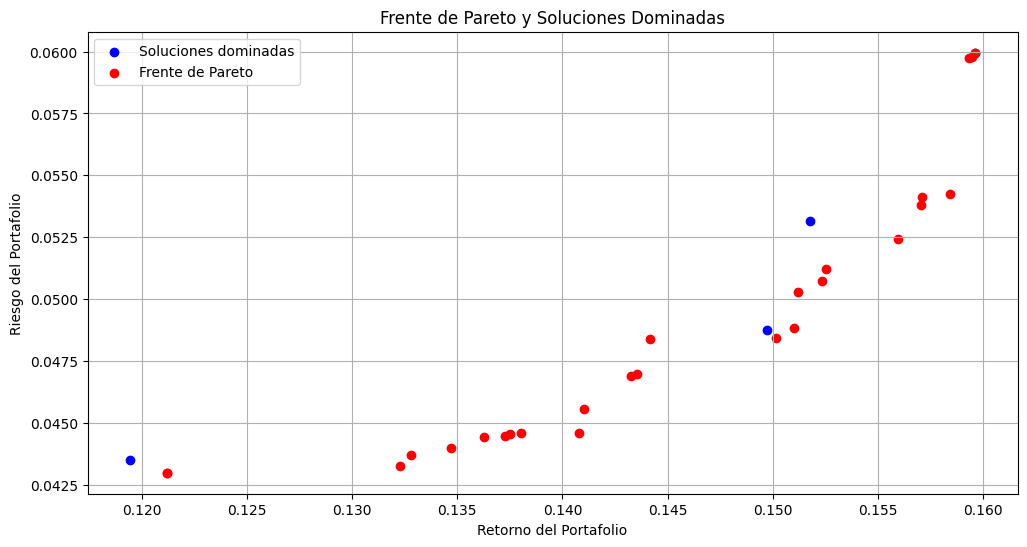

In [14]:
# Ejecutar el algoritmo NSGA-II
pop, log, hof = run_nsga2(toolbox, stats=stats)

# Extraer soluciones no dominadas
frente_pareto = np.array([ind.fitness.values for ind in hof])

frente_pareto2 = np.array([evaluate_portfolio(ind) for ind in hof])

# Extraer todas las soluciones
todas_soluciones = np.array([ind.fitness.values for ind in pop])

# Filtrar soluciones dominadas
sol_dominadas = [ind for ind in pop if ind not in hof]
frente_dominado = np.array([ind.fitness.values for ind in sol_dominadas])

# Visualizar resultados
plt.figure(figsize=(12, 6))

# Graficar soluciones dominadas
if frente_dominado.size > 0:
    plt.scatter(frente_dominado[:, 0], frente_dominado[:, 1], color='blue', label='Soluciones dominadas')

# Graficar frente de Pareto no dominado
plt.scatter(frente_pareto[:, 0], frente_pareto[:, 1], color='red', label='Frente de Pareto')

plt.title('Frente de Pareto y Soluciones Dominadas')
plt.xlabel('Retorno del Portafolio')
plt.ylabel('Riesgo del Portafolio')
plt.legend()
plt.grid(True)
plt.show()